Epoch 1/720


<ipython-input-24-32ba14f7b41c>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0041
Epoch 2/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018
Epoch 3/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.3088e-04
Epoch 4/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7372e-04
Epoch 5/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.7137e-04
Epoch 6/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9857e-04
Epoch 7/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1348e-04
Epoch 8/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9347e-04
Epoch 9/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5356e-04
Epoch 10/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4017e-04
Epoch 11/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4323e-04
Epoch 12/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1628e-04
Epoch 13/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1437e-04
Epoch 14/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2338e-04
Epoch 15/720
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/ste

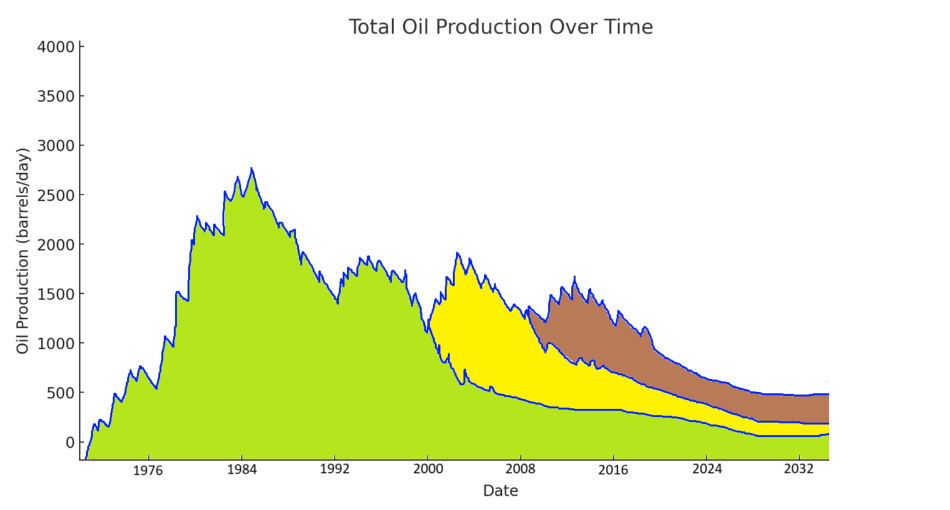

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance

# Load dataset
df = pd.read_csv('oil_well_data.csv')

# --- Exploratory Data Analysis ---
print("First few records:\n", df.head())
print("\nData Summary:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# --- Feature Engineering ---
# Fill or drop missing values
df.fillna(df.median(), inplace=True)

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Normalize continuous variables
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('redeveloped')
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Define features and target
X = df.drop(columns='redeveloped')
y = df['redeveloped']

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Model Training ---
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Optional: Hyperparameter tuning (takes longer)
# params = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'subsample': [0.8, 1]
# }
# grid = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=3, n_jobs=-1)
# grid.fit(X_train, y_train)
# model = grid.best_estimator_

model.fit(X_train, y_train)

# --- Model Evaluation ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# --- Feature Importance ---
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=15)
plt.title('Top 15 Important Features')
plt.show()

# --- Prediction on new well data ---
# Simulated new well data
new_well = pd.DataFrame([{
    'initial_production_rate': 1200,
    'current_production_rate': 100,
    'age_of_well': 35,
    'number_of_workovers': 2,
    'cumulative_production': 500000,
    'last_intervention_type_hydraulic_fracturing': 1,
    'last_intervention_type_none': 0,
    # Add all other necessary dummy variables here
}])

# Ensure new well has all required columns
missing_cols = set(X.columns) - set(new_well.columns)
for col in missing_cols:
    new_well[col] = 0
new_well = new_well[X.columns]  # Ensure same column order

plt.legend()
plt.title("Total Oil Production over time")
plt.show()
